# Exploring the AIND-ephys outputs using SpikeInterface

### Notebook usage:
- This notebook will allow you to visualize and explore the spike sorting results. 
- This is quite slow for large datasets if you are not using the curation GUI.
- This notebook assumes some comfort with spike sorting and electrophysiology data. In addition, a basic understanding of [SpikeInterface](https://spikeinterface.readthedocs.io/en/latest/index.html) is helpful.

#### Requirements:
- processed AINDS neuropixels data
- installation of spikeinterface - if not installed, please install SpikeInterace using the following command:
```bash
pip install "spikeinterface[full, widgets]"
```

**Note**: This notebook is based on the latest version of SpikeInterface (`spikeinterface==0.102.2`) which is under development. The API may change in the future. We have adapted the notebook to work with the latest version of SpikeInterface since there is a significant improvement in the API and functionality. Please note that the AINDS pipeline containers utilize `spikeinterface==0.102.2`.

In [1]:
#import packages
import os
import matplotlib.pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
from spikeinterface.curation import apply_sortingview_curation
from spikeinterface.widgets import plot_sorting_summary

In [2]:
#Fetch data directories

raw_rec = 'path/to/raw/recording'
baseFolder = r"C:\Users\janet\Documents\Example_AINDS_outputs\output" #edit this to the location of your data"
experiment = 'block0_imec0.ap_recording1' #edit this to the name of your experiment folder

## The `preprocessed` folder contains the output of the preprocessing steps including the JSON files associated with each data stream and motion folders. The preprocssed JSON files can be used to re-instantiate the recordings, if the raw data folder is mapped to the same location as the input of the pipeline. 

## The `spikesorted` folder contains the *raw* spike sporting outputs from KS2.5, KS4, or SpyKingCircus.

## The `postprocessed` folder contains the output of the post-processing in `zarr` format. The `sorting_analyzer` includes many computed extensions including the following: 
* removal of duplicate units
* computed amplitudes
* spike/unit locations 
* PCA
* correlograms
* template similarity
* templeate metrics
* QC metrics

## The `curated` folder includes units that *have been* automatically curated by:
* ISI violation ratio
* presence ratio
* amplitude cutoff

### First, choose the data you would like to load:

In [ ]:
data_load = 'post and curated' 

if data_load == 'raw':
    preJSON = os.path.join(preProcessed, experiment + '.json')
    preProcessed = baseFolder + '/preprocessed'
    data = si.load_extractor(preJSON, base_folder=raw_rec)
elif data_load == 'raw_sorting':
    spikes = baseFolder + '/spikesorted'
    data = si.load_extractor("path-to-spikesorted-folder")
elif data_load == 'postprocessed':
    postProcessed = baseFolder + '/postprocessed'
    data = si.load_sorting_analyzer(os.path.join(postProcessed, experiment +'.zarr'))
elif data_load == 'curated':
    curated = baseFolder + '/curated'
    data = si.load_extractor(os.path.join(curated, experiment))
elif data_load == 'post and curated':
    postProcessed = baseFolder + '/postprocessed'
    curated = baseFolder + '/curated'
    sorting_analyzer = si.load_sorting_analyzer(os.path.join(postProcessed, experiment +'.zarr'))
    sorting_curated = si.load_extractor(os.path.join(curated, experiment))

### Each object has various extensions and attributes. You can fetch the extensions using `.get_saved_extension_names()` or with `dir(object)`.

In [11]:
sorting_analyzer.get_saved_extension_names() #or dir(data)

['correlograms',
 'isi_histograms',
 'noise_levels',
 'principal_components',
 'quality_metrics',
 'random_spikes',
 'spike_amplitudes',
 'spike_locations',
 'template_metrics',
 'template_similarity',
 'templates',
 'unit_locations',
 'waveforms']

### You can load different extensions from different steps of the pipeline as well. Here, we will look through the `spikesorted` and `postprocessed` folders.

In [12]:
#quality metrics
qm=sorting_analyzer.get_extension(extension_name='quality_metrics').get_data()

#fetch decoder labels (e.g. SUA, MUA, noise)
labels = sorting_curated.get_property('decoder_label')

#fetch unit ids and locations
unit_ids = sorting_curated.get_unit_ids()
unit_locations = sorting_analyzer.get_extension("unit_locations").get_data()
unit_locations = unit_locations[:,1]


In [13]:
#create dataframe of all the quality metrics
import pandas as pd
df = pd.DataFrame(qm)
df['unit_ids'] = unit_ids
df['labels'] = labels
df['unit_locations'] = unit_locations
df

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,d_prime,drift_mad,drift_ptp,drift_std,firing_range,firing_rate,...,rp_violations,silhouette,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8,unit_ids,labels,unit_locations
0,0.000011,0.320813,0.253487,-35.858154,4.231188,2.973661,12.222923,3.998088,19.47,18.092657,...,74,0.085516,0.035,3.228109,0.122691,0.000951,0.000062,0,sua,10.338268
1,0.01705,0.41297,1.345548,-41.19873,2.849463,0.722396,11.68881,2.187561,9.67,5.921335,...,104,0.091463,<NA>,4.155395,0.131717,0.002968,0.000442,1,noise,6.585852
2,0.000639,0.388942,0.229363,-41.19873,2.091571,0.707122,4.932397,1.087706,7.0,5.586701,...,22,0.062272,0.165,3.315055,0.11712,0.000803,0.000067,2,mua,8.326458
3,0.000147,<NA>,<NA>,-32.043457,3.337959,0.495745,5.553756,1.139975,10.6,5.742241,...,6,0.108747,0.045,2.936728,0.117007,0.000651,0.0,3,sua,21.482910
4,<NA>,<NA>,<NA>,-189.590454,9.715464,<NA>,<NA>,<NA>,0.07,0.134601,...,0,0.152345,<NA>,16.751329,0.2,0.002778,0.0,4,sua,12.691121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,0.000617,<NA>,<NA>,-134.277344,3.617514,3.041059,20.075989,2.88035,12.87,4.665804,...,0,0.119199,0.005,10.698264,0.114833,0.000801,0.0,910,sua,690.837784
911,0.002827,<NA>,<NA>,-128.936768,3.85062,<NA>,<NA>,<NA>,16.47,3.147801,...,0,0.039593,0.035,10.165058,0.167003,0.001069,0.000119,911,sua,697.518988
912,0.001052,<NA>,<NA>,-173.950195,5.429526,<NA>,<NA>,<NA>,10.4,2.680809,...,0,0.242798,0.03,13.590355,0.13417,0.001116,0.000139,912,sua,699.544468
913,0.00001,<NA>,<NA>,-63.323975,2.624512,3.247772,15.989197,4.869485,54.21,19.18891,...,518,0.049426,0.195,5.146478,0.139979,0.001013,0.000019,913,mua,699.681617


In [14]:
print("Total units: ", len(sorting_analyzer.unit_ids)), sorting_analyzer.unit_ids

Total units:  860


(None,
 array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150,
        151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166,
        167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 1

### The SpikeInterface objects stores the data for all units. Often, a list of unit_ids is needed to explore the data. Below, we will plot the waveform templates for a list of units.

In [15]:
unit_ids = [0, 3] #list of unit ids to plot

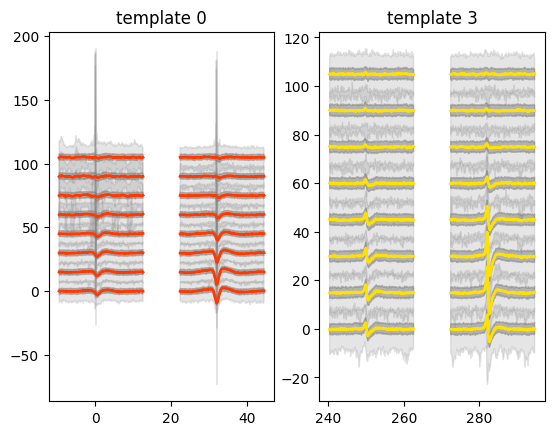

In [18]:
sw.plot_unit_templates(sorting_analyzer, unit_ids=unit_ids)

### To fetch spike trains you can use the following logic:

In [24]:
unit_id = 1

spikes = baseFolder + '/spikesorted'
spike_extractor = si.load_extractor(os.path.join(spikes, experiment))

#this returns the spike train of a single unit
spike_extractor.get_unit_spike_train(unit_id, return_times=True)

array([2.81333333e-02, 3.77166667e-01, 7.34466667e-01, ...,
       2.67419150e+03, 2.67427063e+03, 2.67456170e+03])

## We hope this provides some intuition on how to explore the AINDS data using SpikeInterface. Please refer to the [SpikeInterface](https://spikeinterface.readthedocs.io/en/latest/index.html) documentation for details about API and usage.